# 🧠 Unit 2.2: Deep Learning for Time Series

**Course:** Advanced Machine Learning (AICC 303)  
**Topic:** 2.5 Recurrent Neural Networks (RNN, LSTM, GRU)

While classical models (ARIMA) are great for linear patterns, Deep Learning excels at capturing complex, non-linear relationships in large datasets.

**In this notebook:**
1.  **Data Preparation:** Converting time series into sequences (Sliding Window).
2.  **RNN:** The foundational recurrent architecture.
3.  **LSTM:** Solving the vanishing gradient problem.
4.  **GRU:** A more efficient variant of LSTM.
5.  **Comparison:** Putting them to the test.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Setup
sns.set(style="whitegrid")
np.random.seed(42)
torch.manual_seed(42)
plt.rcParams['figure.figsize'] = (12, 6)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 1. Data Generation & Preparation

Neural Networks differ from ARIMA in data ingestion. They require the data to be in a supervised learning format: Inputs ($X$) and Outputs ($y$).

**Sliding Window Approach:**
We use the past $N$ time steps to predict the next time step.
*   Sequence: $[10, 20, 30, 40, 50]$
*   Input (Window=3): $[10, 20, 30]$ -> Target: $40$
*   Input (Window=3): $[20, 30, 40]$ -> Target: $50$

In [2]:
# Generate Synthetic Data (Sine wave with Trend + Noise)
t = np.arange(0, 1000)
trend = 0.05 * t
seasonality = 10 * np.sin(0.1 * t)
noise = np.random.normal(0, 1, len(t))
data = trend + seasonality + noise

# Normalize the data (Neural Networks love values between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 50
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Splitting Data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: torch.Size([760, 50, 1])
Testing Shape: torch.Size([190, 50, 1])


## 2. Recurrent Neural Network (RNN)

**Concept:** RNNs have loops, allowing information to persist. They pass a hidden state from one step to the next.

**Problem:** **Vanishing Gradient**. As sequences get longer, it becomes hard for the network to learn dependencies from the distant past.

In [3]:
class TimeSeriesModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1, model_type='RNN'):
        super(TimeSeriesModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        if model_type == 'RNN':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take last time step
        return out

def train_model(model, X_train, y_train, X_test, y_test, epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
    
    return train_losses, val_losses

# Train Simple RNN
rnn_model = TimeSeriesModel(model_type='RNN').to(device)
rnn_train_loss, rnn_val_loss = train_model(rnn_model, X_train, y_train, X_test, y_test)
print("RNN Trained.")

RNN Trained.


## 3. Long Short-Term Memory (LSTM)

**Concept:** LSTMs introduce a "Cell State" and three gates to regulate information flow:
1.  **Forget Gate:** What to throw away?
2.  **Input Gate:** What new info to store?
3.  **Output Gate:** What to pass to the next hidden state?

This architecture solves the vanishing gradient problem, allowing learning of long-term dependencies.

In [4]:
# Train LSTM
lstm_model = TimeSeriesModel(model_type='LSTM').to(device)
lstm_train_loss, lstm_val_loss = train_model(lstm_model, X_train, y_train, X_test, y_test)
print("LSTM Trained.")

LSTM Trained.


## 4. Gated Recurrent Unit (GRU)

**Concept:** A simplified version of LSTM. It combines the Forget and Input gates into a single "Update Gate". It is computationally cheaper than LSTM and often performs just as well.

In [5]:
# Train GRU
gru_model = TimeSeriesModel(model_type='GRU').to(device)
gru_train_loss, gru_val_loss = train_model(gru_model, X_train, y_train, X_test, y_test)
print("GRU Trained.")

GRU Trained.


## 5. Model Comparison

Let's visualize the loss curves and the actual predictions.

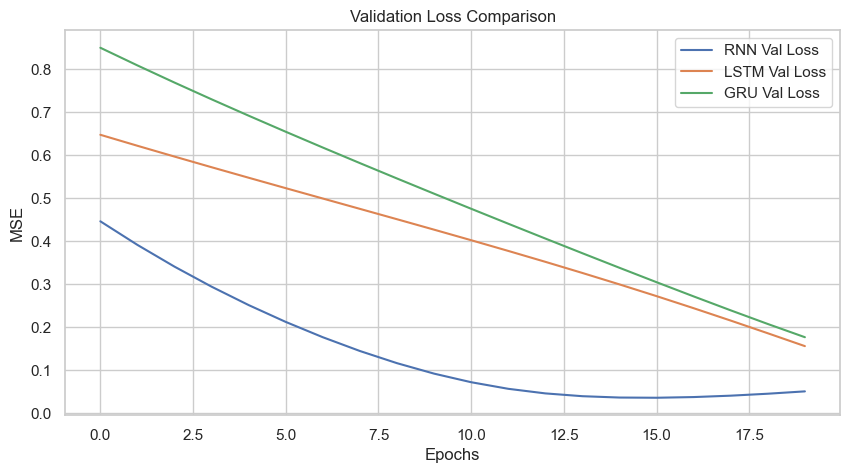

RNN RMSE: 15.4045
LSTM RMSE: 26.9346
GRU RMSE: 28.6656


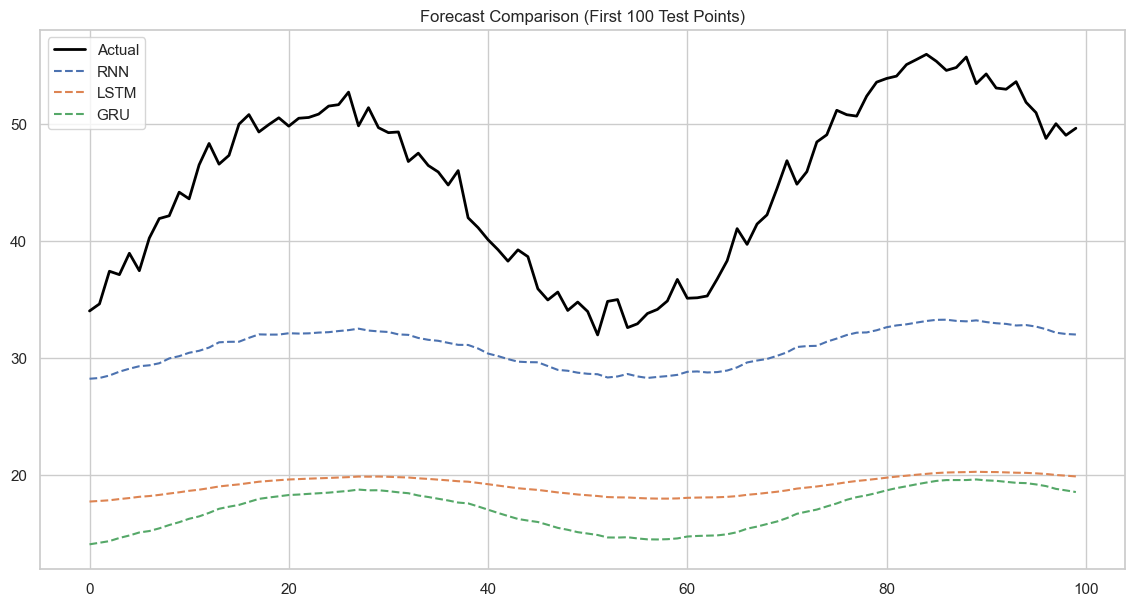

In [6]:
# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(rnn_val_loss, label='RNN Val Loss')
plt.plot(lstm_val_loss, label='LSTM Val Loss')
plt.plot(gru_val_loss, label='GRU Val Loss')
plt.title("Validation Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Make Predictions
rnn_model.eval()
lstm_model.eval()
gru_model.eval()

with torch.no_grad():
    rnn_pred = rnn_model(X_test).cpu().numpy()
    lstm_pred = lstm_model(X_test).cpu().numpy()
    gru_pred = gru_model(X_test).cpu().numpy()
    actual = y_test.cpu().numpy()

# Inverse transform
rnn_pred = scaler.inverse_transform(rnn_pred)
lstm_pred = scaler.inverse_transform(lstm_pred)
gru_pred = scaler.inverse_transform(gru_pred)
actual = scaler.inverse_transform(actual)

# Calculate RMSE
print(f"RNN RMSE: {np.sqrt(mean_squared_error(actual, rnn_pred)):.4f}")
print(f"LSTM RMSE: {np.sqrt(mean_squared_error(actual, lstm_pred)):.4f}")
print(f"GRU RMSE: {np.sqrt(mean_squared_error(actual, gru_pred)):.4f}")

# Visual Comparison (Zooming in on first 100 test points)
plt.figure(figsize=(14, 7))
plt.plot(actual[:100], label='Actual', color='black', linewidth=2)
plt.plot(rnn_pred[:100], label='RNN', linestyle='--')
plt.plot(lstm_pred[:100], label='LSTM', linestyle='--')
plt.plot(gru_pred[:100], label='GRU', linestyle='--')
plt.title("Forecast Comparison (First 100 Test Points)")
plt.legend()
plt.show()

### Conclusion
*   **RNNs** struggle with long-term memory but work for short patterns.
*   **LSTMs** are the gold standard for complex time series.
*   **GRUs** offer a great balance of performance and speed.

For this simple dataset, you might see similar performance, but LSTMs/GRUs will vastly outperform RNNs on longer, more complex sequences.